## Context

- Jamboree has helped thousands of students make it to top colleges abroad. Be it GMAT, GRE or SAT, their unique problem-solving methods ensure maximum scores with minimum effort.
- They recently launched a feature where students/learners can come to their website and check their probability of getting into the IVY league college. This feature estimates the chances of graduate admission from an Indian perspective.


## Problem Statement : 

- Help Jamboree in understanding what factors are important in graduate admissions and how these factors are interrelated among themselves. It will also help predict one's chances of admission given the rest of the variables.


### Column Profiling:

    Serial No. (Unique row ID)
    GRE Scores (out of 340)
    TOEFL Scores (out of 120)
    University Rating (out of 5)
    Statement of Purpose and Letter of Recommendation Strength (out of 5)
    Undergraduate GPA (out of 10)
    Research Experience (either 0 or 1)
    Chance of Admit (ranging from 0 to 1)
    

- Exploratory Data Analysis
- Linear Regression




In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib import figure

import warnings
warnings.filterwarnings('ignore')

import statsmodels.api as sm


In [3]:
data = pd.read_csv("/content/Jamboree_Admission.csv")

In [5]:
data.shape

(500, 9)

In [6]:
df = data.copy()

# dropping first  not required column "Serial No."

In [7]:
df.drop(["Serial No."],axis=1,inplace=True)

In [8]:
# null values check 
df.isna().sum()

GRE Score            0
TOEFL Score          0
University Rating    0
SOP                  0
LOR                  0
CGPA                 0
Research             0
Chance of Admit      0
dtype: int64

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   GRE Score          500 non-null    int64  
 1   TOEFL Score        500 non-null    int64  
 2   University Rating  500 non-null    int64  
 3   SOP                500 non-null    float64
 4   LOR                500 non-null    float64
 5   CGPA               500 non-null    float64
 6   Research           500 non-null    int64  
 7   Chance of Admit    500 non-null    float64
dtypes: float64(4), int64(4)
memory usage: 31.4 KB


### No null values detected 

In [10]:
df.nunique()

GRE Score             49
TOEFL Score           29
University Rating      5
SOP                    9
LOR                    9
CGPA                 184
Research               2
Chance of Admit       61
dtype: int64

#### University Rating,SOP,LOR,Research are seems to be categorical variables as the number of unique values are very small.
#### rest of the features are numeric , and ordinal . (University Rating,SOP,LOR,Research are discrete ) and rest are continuous
#### also if SOP , University rating , LOR and research can be considered as numeric ordinal data.

## Overall look at correlation : 


<Axes: >

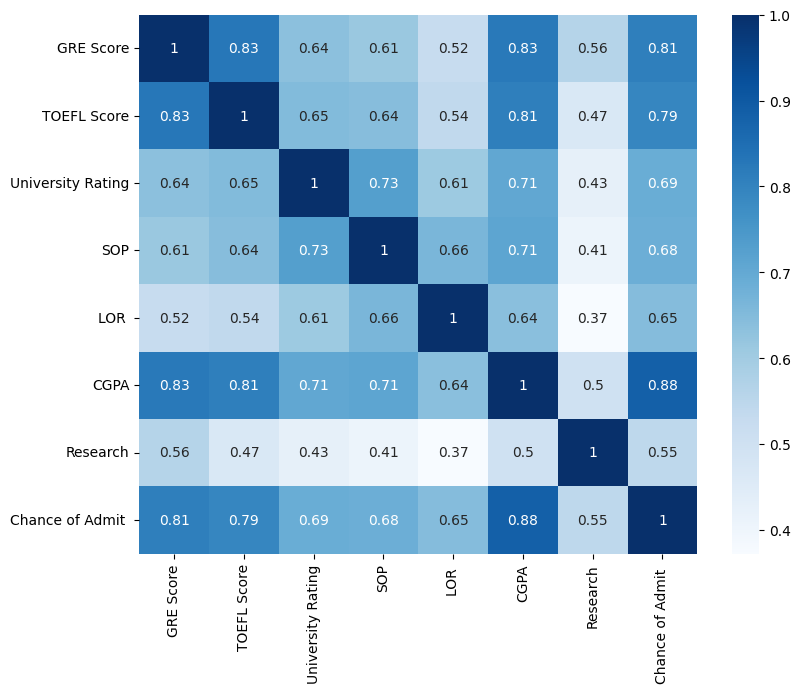

In [12]:
plt.figure(figsize=(9,7))
sns.heatmap(df.corr(),annot=True,cmap = "Blues")

- Independent Variables (Input data): GRE Score, TOEFL Score, University Rating, SOP, LOR, CGPA, Research 
- Target/Dependent Variable : Chance of Admit (the value we want to predict)


- from above correlation heatmap , we can observe GRE score TOEFL score and CGPA have very high correlation with Change of admission.

-  University rating, SOP ,LOR and Research have comparatively slightly less correlated than other features.

In [13]:
df.columns

Index(['GRE Score', 'TOEFL Score', 'University Rating', 'SOP', 'LOR ', 'CGPA',
       'Research', 'Chance of Admit '],
      dtype='object')

In [14]:
# changing / removing space between column names.
df.columns  = ['GRE_Score', 'TOEFL_Score', 'University_Rating', 'SOP', 'LOR', 'CGPA',
       'Research', 'Chance_of_Admit']

In [15]:
df.sample(2)

,GRE_Score,TOEFL_Score,University_Rating,SOP,LOR,CGPA,Research,Chance_of_Admit
277,320,101,2,2.5,3.0,8.62,0,0.70
396,325,107,3,3.0,3.5,9.11,1,0.84


# Outliers in the data :

In [16]:

def detect_outliers(data):
    length_before = len(data)
    Q1 = np.percentile(data,25)
    Q3 = np.percentile(data,75)
    IQR = Q3-Q1
    upperbound = Q3+1.5*IQR
    lowerbound = Q1-1.5*IQR
    if lowerbound < 0:
        lowerbound = 0
    
    length_after = len(data[(data>lowerbound)&(data<upperbound)])
    return f"{np.round((length_before-length_after)/length_before,4)} % Outliers data from input data found"

In [17]:
for col in df.columns:
    print(col," : ",detect_outliers(df[col]))

GRE_Score  :  0.0 % Outliers data from input data found
TOEFL_Score  :  0.0 % Outliers data from input data found
University_Rating  :  0.0 % Outliers data from input data found
SOP  :  0.0 % Outliers data from input data found
LOR  :  0.024 % Outliers data from input data found
CGPA  :  0.0 % Outliers data from input data found
Research  :  0.44 % Outliers data from input data found
Chance_of_Admit  :  0.004 % Outliers data from input data found


In [18]:
detect_outliers(df)

'0.0 % Outliers data from input data found'

# Descriptive analysis of all numerical features : 

In [19]:
df.describe()

,GRE_Score,TOEFL_Score,University_Rating,SOP,LOR,CGPA,Research,Chance_of_Admit
count,500.000000,500.000000,500.000000,500.000000,500.00000,500.000000,500.000000,500.00000
mean,316.472000,107.192000,3.114000,3.374000,3.48400,8.576440,0.560000,0.72174
std,11.295148,6.081868,1.143512,0.991004,0.92545,0.604813,0.496884,0.14114
min,290.000000,92.000000,1.000000,1.000000,1.00000,6.800000,0.000000,0.34000
25%,308.000000,103.000000,2.000000,2.500000,3.00000,8.127500,0.000000,0.63000
50%,317.000000,107.000000,3.000000,3.500000,3.50000,8.560000,1.000000,0.72000
75%,325.000000,112.000000,4.000000,4.000000,4.00000,9.040000,1.000000,0.82000
max,340.000000,120.000000,5.000000,5.000000,5.00000,9.920000,1.000000,0.97000


- chances of admit is a probability measure , which is within 0 to 1 which is good (no outliers or missleading data in column). 
- Range of GRE score looks like between 290 to 340.
- range of TOEFL score is between 92 to 120.
- university rating , SOP and LOR are distributed between range of 1 to 5.
- CGPA range is between  6.8 to 9.92.

# Graphical Analysis : 

### Chance_of_Admit

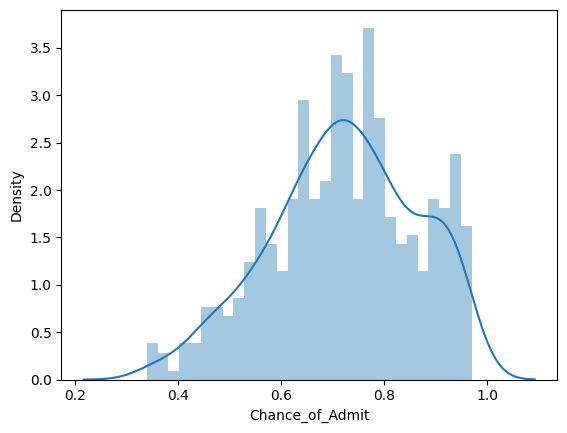

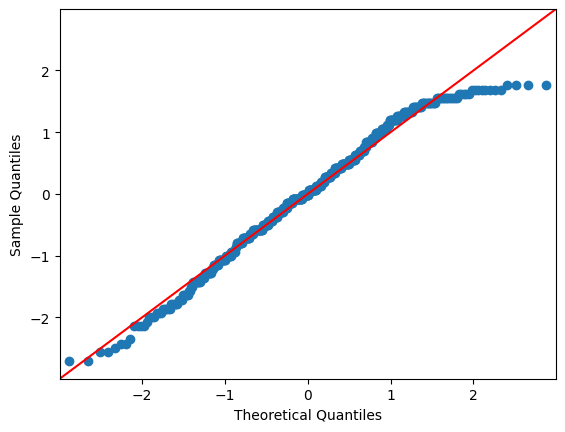

In [21]:
sns.distplot(df["Chance_of_Admit"],bins = 30)
sm.qqplot(df["Chance_of_Admit"],fit=True, line="45")
plt.show()

### GRE_Score

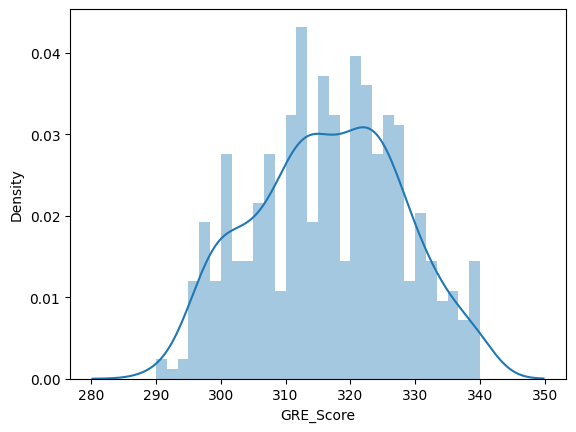

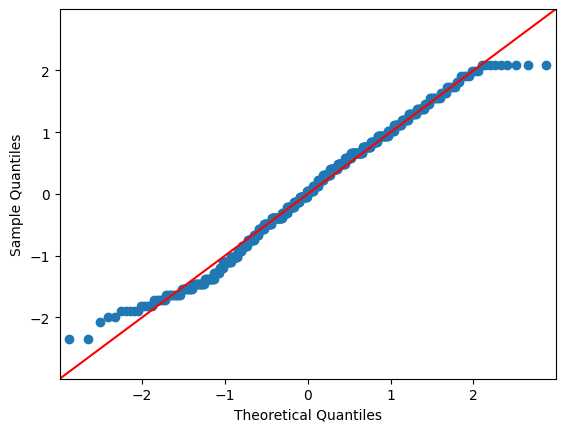

In [22]:
sns.distplot(df["GRE_Score"], bins = 30)
sm.qqplot(df["GRE_Score"],fit=True, line="45")
plt.show()

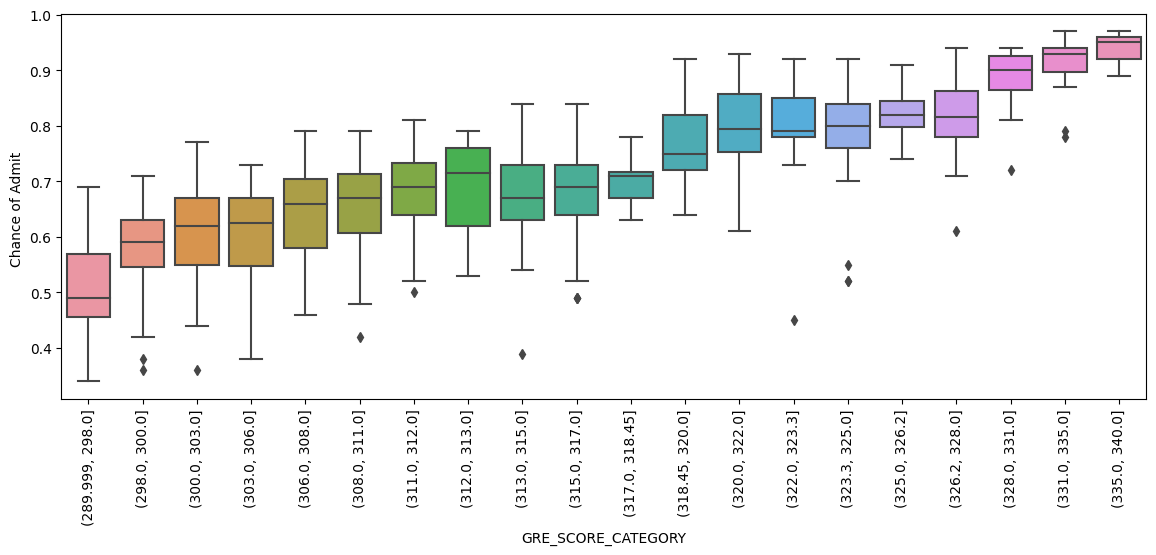

In [23]:
data["GRE_SCORE_CATEGORY"]=pd.qcut(data["GRE Score"],20)
plt.figure(figsize=(14,5))
sns.boxplot(y = data["Chance of Admit "], x = data["GRE_SCORE_CATEGORY"])
plt.xticks(rotation = 90)
plt.show()

##### From above boxplot (distribution of chance of admition (probability of getting admition) as per GRE score  ) :
#####  with higher GRE score , there is high probability of getting an admition . 

### TOEFL_Score

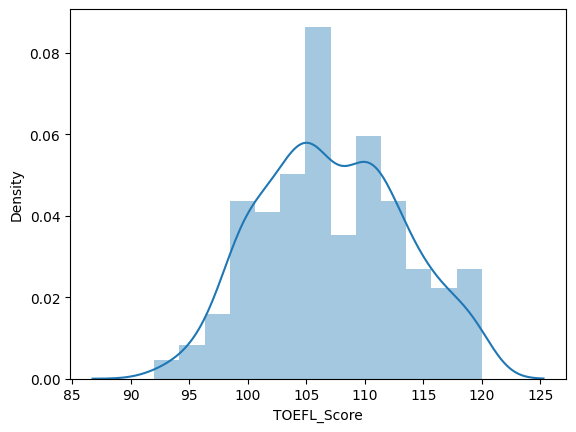

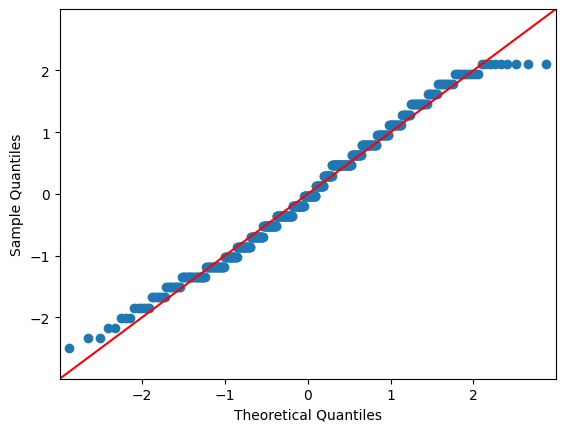

<Axes: xlabel='TOEFL_Score', ylabel='Chance_of_Admit'>

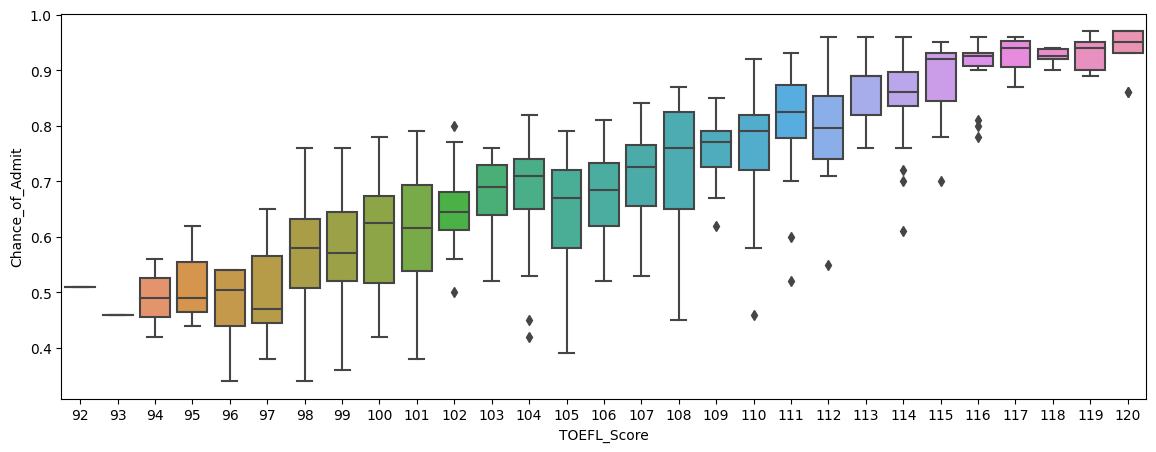

In [25]:
# TOEFL_Score                 

sns.distplot(df["TOEFL_Score"])
sm.qqplot(df["TOEFL_Score"],fit=True, line="45")
plt.show()
plt.figure(figsize=(14,5))
sns.boxplot(y = df["Chance_of_Admit"], x = df["TOEFL_Score"])

####  Students having high toefl score , has higher probability of getting admition . 

#### Chance of admit and GRE score are nearly normally distrubted.

## Linearity : How features are correlated with Target variable - chance of admit : 

GRE_Score


<Figure size 300x300 with 0 Axes>

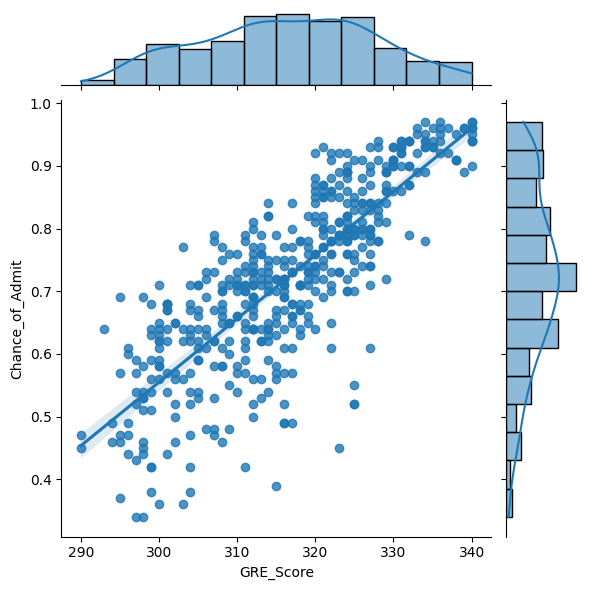

TOEFL_Score


<Figure size 300x300 with 0 Axes>

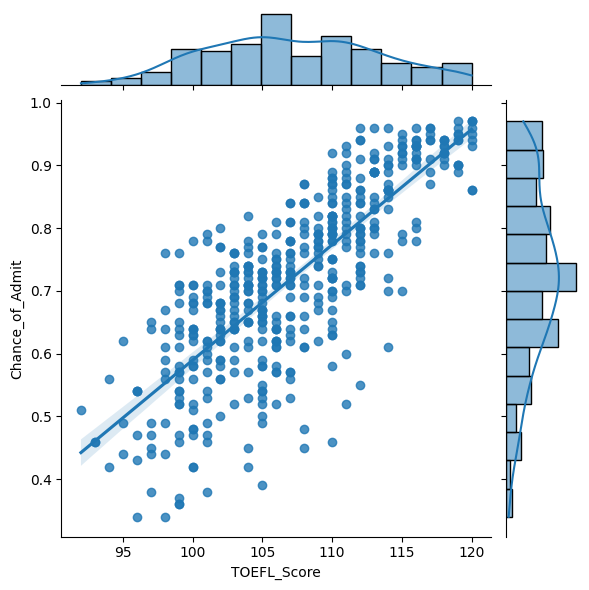

University_Rating


<Figure size 300x300 with 0 Axes>

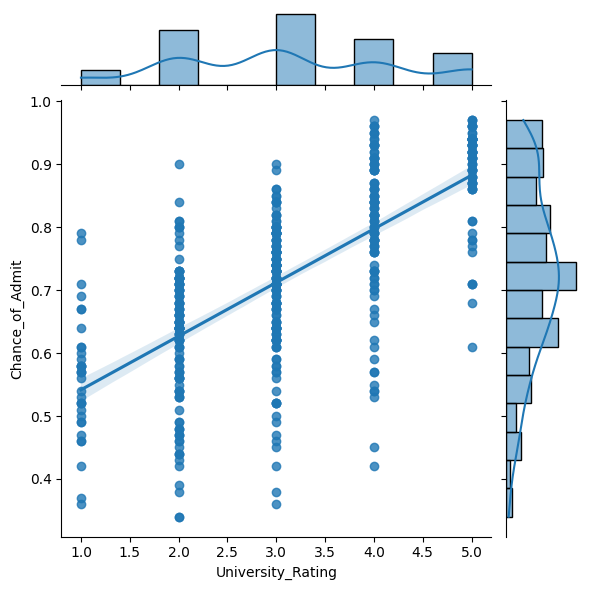

SOP


<Figure size 300x300 with 0 Axes>

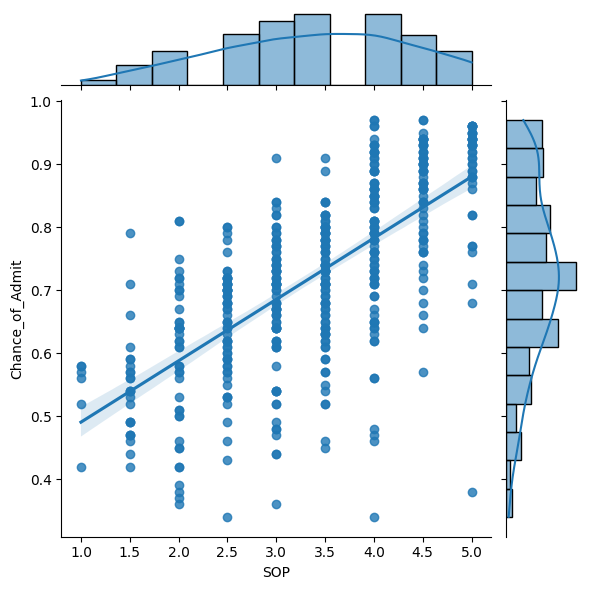

LOR


<Figure size 300x300 with 0 Axes>

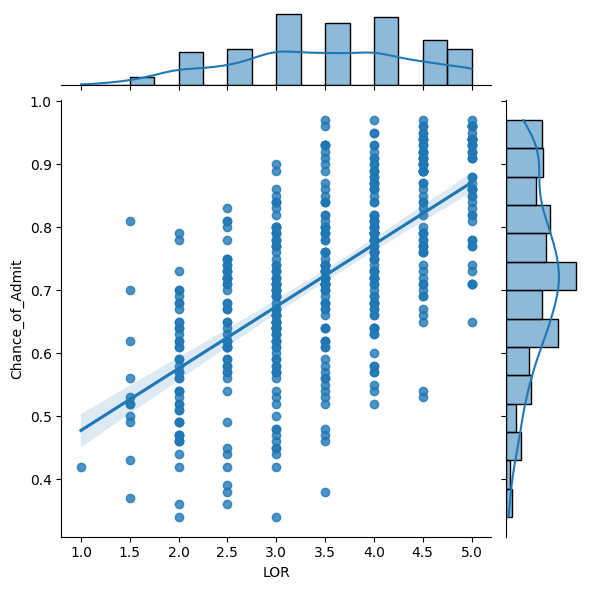

CGPA


<Figure size 300x300 with 0 Axes>

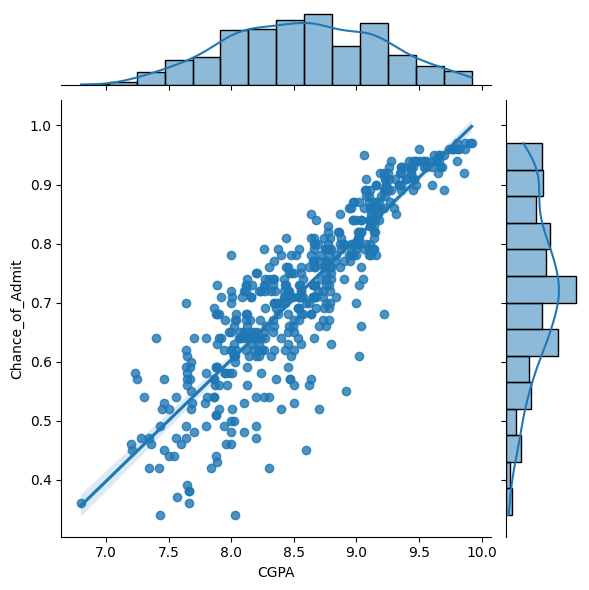

Research


<Figure size 300x300 with 0 Axes>

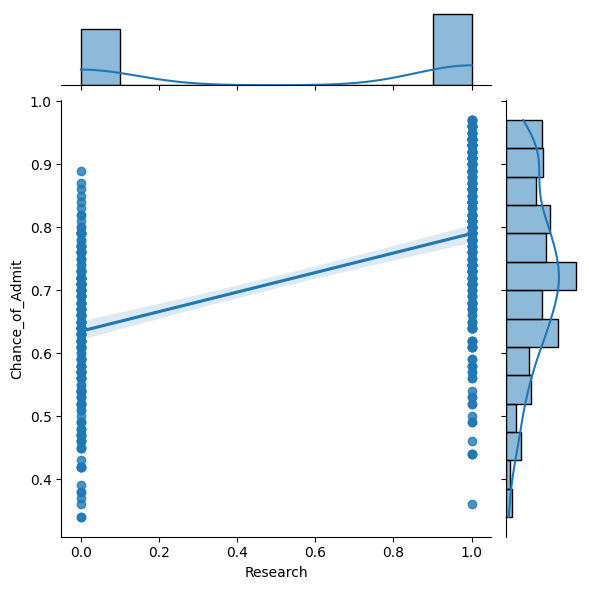

In [31]:
for col in df.columns[:-1]:
    print(col)
    plt.figure(figsize=(3,3))
    sns.jointplot(x=df[col],y=df["Chance_of_Admit"],kind="reg")
    plt.show()

# Linear Regression : 

In [32]:
from sklearn.preprocessing import StandardScaler

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

from statsmodels.stats.outliers_influence import variance_inflation_factor

from sklearn.metrics import r2_score,mean_squared_error,mean_absolute_error, adjusted_mutual_info_score
from sklearn.feature_selection import f_regression

In [33]:
X = df.drop(["Chance_of_Admit"],axis = 1)  # independent variables
y = df["Chance_of_Admit"].values.reshape(-1,1) # target / dependent variables

#### Standardising data


In [34]:
standardizer = StandardScaler()   
standardizer.fit(X)
x = standardizer.transform(X)  # standardising the data

#### test train spliting : 


In [35]:
X_train , X_test, y_train , y_test = train_test_split(x,y,
                                                     random_state = 1,
                                                      test_size = 0.2 
                                                     )                         # test train split 

In [36]:
X_train.shape,X_test.shape  # after spliting, checking for the shape of test and  train data

((400, 7), (100, 7))

In [37]:
y_train.shape, y_test.shape

((400, 1), (100, 1))

### training the model 

In [38]:
LinearRegression = LinearRegression()    # training LinearRegression model 
LinearRegression.fit(X_train,y_train)

LinearRegression()

### r2 score on train data : 

In [39]:
r2_score(y_train,LinearRegression.predict(X_train))

0.8215099192361265

### r2 score on test data : 

In [40]:
r2_score(y_test,LinearRegression.predict(X_test) )

0.8208741703103732

### All the feature's coefficients and Intercept : 

In [41]:
ws = pd.DataFrame(LinearRegression.coef_.reshape(1,-1),columns=df.columns[:-1])
ws["Intercept"] = LinearRegression.intercept_
ws

,GRE_Score,TOEFL_Score,University_Rating,SOP,LOR,CGPA,Research,Intercept
0,0.020675,0.019284,0.007001,0.002975,0.013338,0.070514,0.009873,0.722881


In [42]:
LinearRegression_Model_coefs = ws
LinearRegression_Model_coefs

,GRE_Score,TOEFL_Score,University_Rating,SOP,LOR,CGPA,Research,Intercept
0,0.020675,0.019284,0.007001,0.002975,0.013338,0.070514,0.009873,0.722881


In [43]:
def AdjustedR2score(R2,n,d):
    return 1-(((1-R2)*(n-1))/(n-d-1))

In [44]:
y_pred = LinearRegression.predict(X_test)

print("MSE:",mean_squared_error(y_test,y_pred)) # MSE
print("RMSE:",np.sqrt(mean_squared_error(y_test,y_pred))) #RMSE
print("MAE :",mean_absolute_error(y_test,y_pred) ) # MAE
print("r2_score:",r2_score(y_test,y_pred)) # r2score
print("Adjusted R2 score :", AdjustedR2score(r2_score(y_test,y_pred),len(X),X.shape[1]))  # adjusted R2 score

MSE: 0.0034590988971363815
RMSE: 0.05881410457650768
MAE : 0.040200193804157944
r2_score: 0.8208741703103732
Adjusted R2 score : 0.8183256320830818


### Assumptions of linear regression
* No multicollinearity
* The mean of residual is nearly zero.
* Linearity of Variables
* Test of homoscedasticity
* Normality of residual

## Multicollinearity check : 
- checking vif scores : 

In [45]:
vifs = []

for i in range(X_train.shape[1]):
    
    vifs.append((variance_inflation_factor(exog = X_train,
                                   exog_idx=i)))
vifs

[4.873264779539272,
 4.243883338617031,
 2.798251888543383,
 2.9200455031169206,
 2.079334304516445,
 4.751389166380193,
 1.5081475402055684]

In [46]:
pd.DataFrame({ "coef_name : " : X.columns ,
             "vif : ": np.around(vifs,2)})

,coef_name :,vif :
0,GRE_Score,4.87
1,TOEFL_Score,4.24
2,University_Rating,2.80
3,SOP,2.92
4,LOR,2.08
5,CGPA,4.75
6,Research,1.51


#### VIF score are all below 5 ,  doesnt seem to have very high multicolinearity. 

## Residual analysis : 

In [47]:
y_predicted = LinearRegression.predict(X_train)
y_predicted.shape

(400, 1)

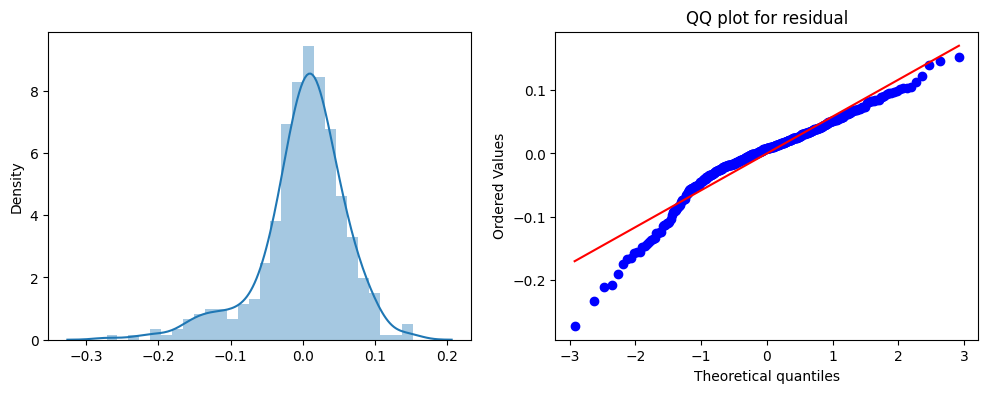

In [49]:
from scipy import stats
residuals = (y_train - y_predicted)
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
sns.distplot(residuals)
plt.subplot(1,2,2)
stats.probplot(residuals.reshape(-1,), plot = plt)
plt.title('QQ plot for residual')
plt.show()

#### Linearity of varibales


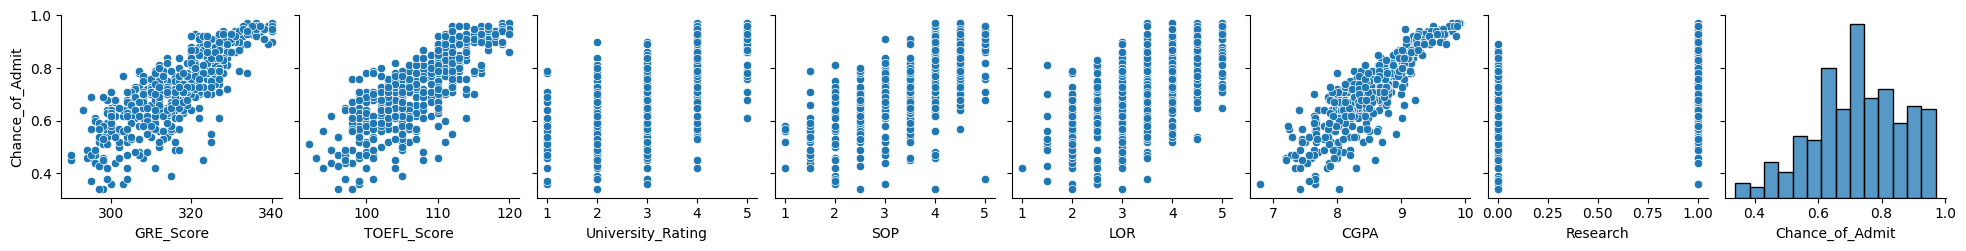

In [50]:
sns.pairplot(df,y_vars = ["Chance_of_Admit"])
plt.show()

#### Test of homoscedasticity | plotting y_predicted and residuals 


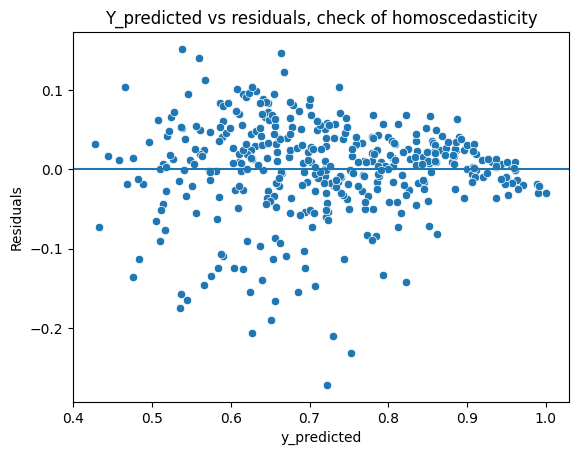

In [51]:
# Test of homoscedasticity
sns.scatterplot(x=y_predicted.reshape(-1,), y=residuals.reshape(-1,))
plt.xlabel('y_predicted')
plt.ylabel('Residuals')
plt.axhline(y=0)
plt.title("Y_predicted vs residuals, check of homoscedasticity")
plt.show()

# Model Regularisation  : 

In [52]:
from sklearn.linear_model import Ridge  # L2 regualrization
from sklearn.linear_model import Lasso  # L1 regualrization 
from sklearn.linear_model import ElasticNet

## L2 regularization 
## Ridge regression : 

In [53]:
## Hyperparameter Tuning : for appropriate lambda value : 

train_R2_score = []
test_R2_score = []
lambdas = []
train_test_difference_Of_R2 =  []
lambda_ = 0
while lambda_ <= 5:
    lambdas.append(lambda_)
    RidgeModel = Ridge(lambda_)
    RidgeModel.fit(X_train,y_train)
    trainR2 = RidgeModel.score(X_train,y_train)
    testR2 = RidgeModel.score(X_test,y_test)
    train_R2_score.append(trainR2)
    test_R2_score.append(testR2)
    
    lambda_ += 0.01  

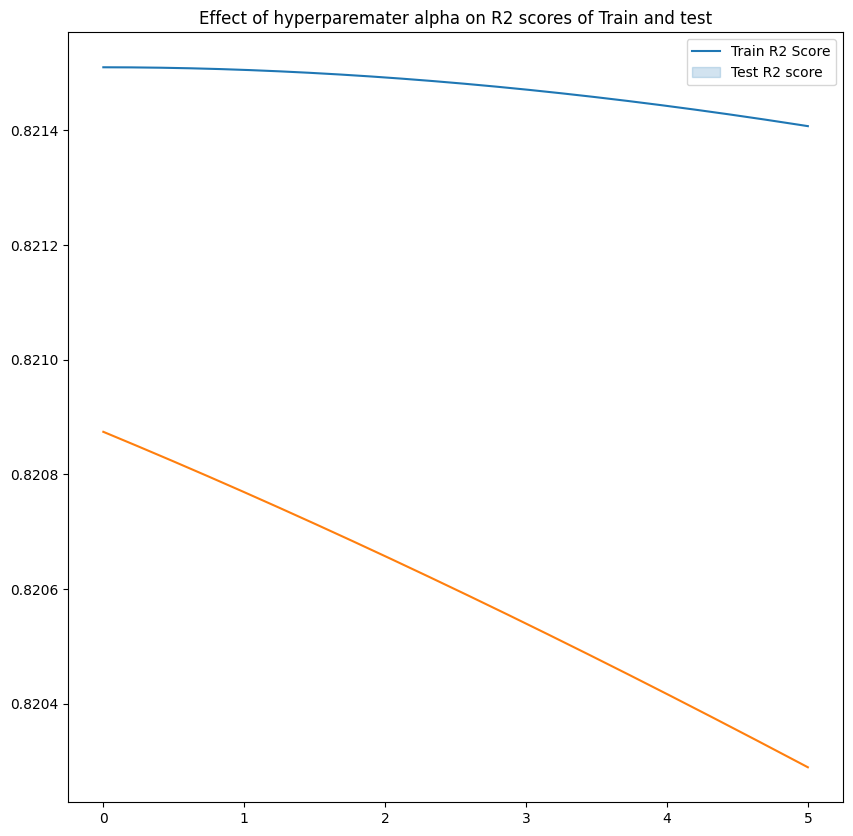

In [54]:
plt.figure(figsize = (10,10))
sns.lineplot(x=lambdas,y=train_R2_score,)
sns.lineplot(x=lambdas, y=test_R2_score)
plt.legend(['Train R2 Score','Test R2 score'])
plt.title("Effect of hyperparemater alpha on R2 scores of Train and test")


plt.show()

In [55]:
RidgeModel = Ridge(alpha = 0.1)
RidgeModel.fit(X_train,y_train)
trainR2 = RidgeModel.score(X_train,y_train)
testR2 = RidgeModel.score(X_test,y_test)

In [56]:
trainR2,testR2

(0.8215098726041208, 0.8208639536156423)

In [57]:
RidgeModel.coef_

array([[0.02069489, 0.01929637, 0.00700953, 0.00298992, 0.01334235,
        0.07044884, 0.00987467]])

In [58]:
RidgeModel_coefs = pd.DataFrame(RidgeModel.coef_.reshape(1,-1),columns=df.columns[:-1])
RidgeModel_coefs["Intercept"] = RidgeModel.intercept_
RidgeModel_coefs

,GRE_Score,TOEFL_Score,University_Rating,SOP,LOR,CGPA,Research,Intercept
0,0.020695,0.019296,0.00701,0.00299,0.013342,0.070449,0.009875,0.722882


In [59]:
LinearRegression_Model_coefs

,GRE_Score,TOEFL_Score,University_Rating,SOP,LOR,CGPA,Research,Intercept
0,0.020675,0.019284,0.007001,0.002975,0.013338,0.070514,0.009873,0.722881


In [60]:
y_pred = RidgeModel.predict(X_test)

print("MSE:",mean_squared_error(y_test,y_pred)) # MSE
print("RMSE:",np.sqrt(mean_squared_error(y_test,y_pred))) #RMSE
print("MAE :",mean_absolute_error(y_test,y_pred) ) # MAE
print("r2_score:",r2_score(y_test,y_pred)) # r2score
print("Adjusted R2 score :", AdjustedR2score(r2_score(y_test,y_pred),len(X),X.shape[1]))  # adjusted R2 score

MSE: 0.00345929619172833
RMSE: 0.05881578182535985
MAE : 0.04020305511705695
r2_score: 0.8208639536156423
Adjusted R2 score : 0.818315270028873


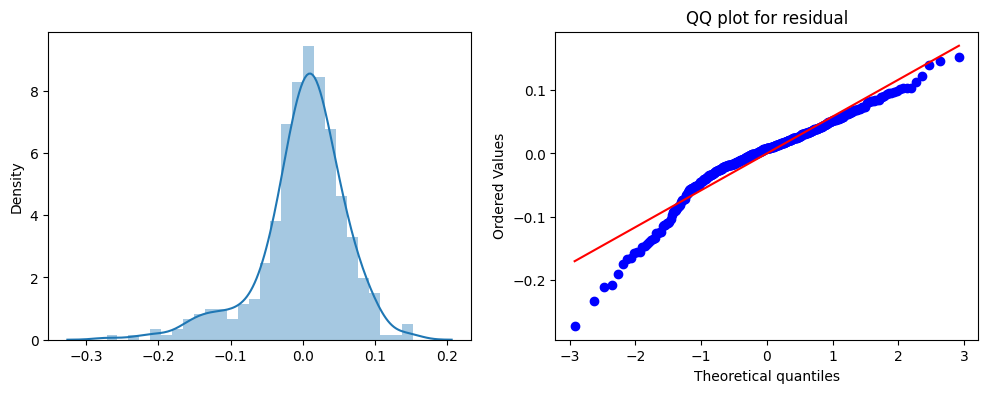

In [61]:
y_predicted = RidgeModel.predict(X_train)
import seaborn as sns
from scipy import stats
import matplotlib.pyplot as plt
residuals = (y_train - y_predicted)
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
sns.distplot(residuals)
plt.subplot(1,2,2)
stats.probplot(residuals.reshape(-1,), plot = plt)
plt.title('QQ plot for residual')
plt.show()

## L1 regularization : 
## Lasso : 

In [62]:
## Hyperparameter Tuning : for appropriate lambda value : 

train_R2_score = []
test_R2_score = []
lambdas = []
train_test_difference_Of_R2 =  []
lambda_ = 0
while lambda_ <= 5:
    lambdas.append(lambda_)
    LassoModel = Lasso(alpha=lambda_)
    LassoModel.fit(X_train , y_train)
    trainR2 = LassoModel.score(X_train,y_train)
    testR2 = LassoModel.score(X_test,y_test)
    train_R2_score.append(trainR2)
    test_R2_score.append(testR2)
    
    lambda_ += 0.001

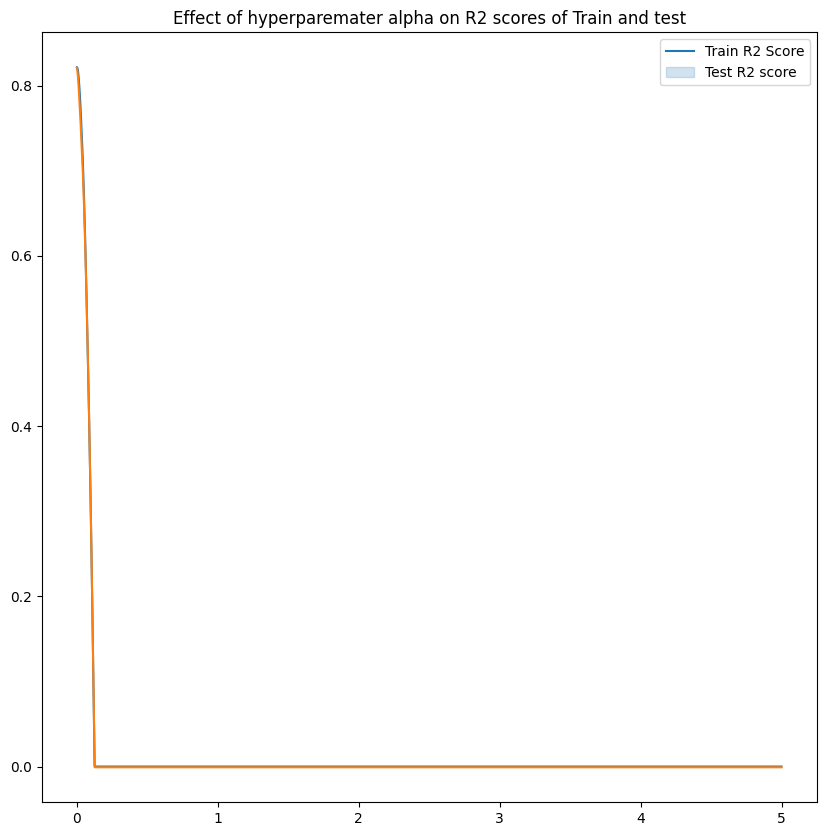

In [63]:
plt.figure(figsize = (10,10))
sns.lineplot(x=lambdas,y=train_R2_score,)
sns.lineplot(x=lambdas, y=test_R2_score)
plt.legend(['Train R2 Score','Test R2 score'])
plt.title("Effect of hyperparemater alpha on R2 scores of Train and test")


plt.show()

In [64]:
LassoModel = Lasso(alpha=0.001)
LassoModel.fit(X_train , y_train)
trainR2 = LassoModel.score(X_train,y_train)
testR2 = LassoModel.score(X_test,y_test)

In [65]:
trainR2,testR2

(0.82142983289567, 0.8198472607571161)

In [66]:
Lasso_Model_coefs = pd.DataFrame(LassoModel.coef_.reshape(1,-1),columns=df.columns[:-1])
Lasso_Model_coefs["Intercept"] = LassoModel.intercept_
Lasso_Model_coefs

,GRE_Score,TOEFL_Score,University_Rating,SOP,LOR,CGPA,Research,Intercept
0,0.020616,0.019069,0.006782,0.002808,0.012903,0.070605,0.009278,0.722863


In [67]:
RidgeModel_coefs

,GRE_Score,TOEFL_Score,University_Rating,SOP,LOR,CGPA,Research,Intercept
0,0.020695,0.019296,0.00701,0.00299,0.013342,0.070449,0.009875,0.722882


In [68]:
LinearRegression_Model_coefs

,GRE_Score,TOEFL_Score,University_Rating,SOP,LOR,CGPA,Research,Intercept
0,0.020675,0.019284,0.007001,0.002975,0.013338,0.070514,0.009873,0.722881


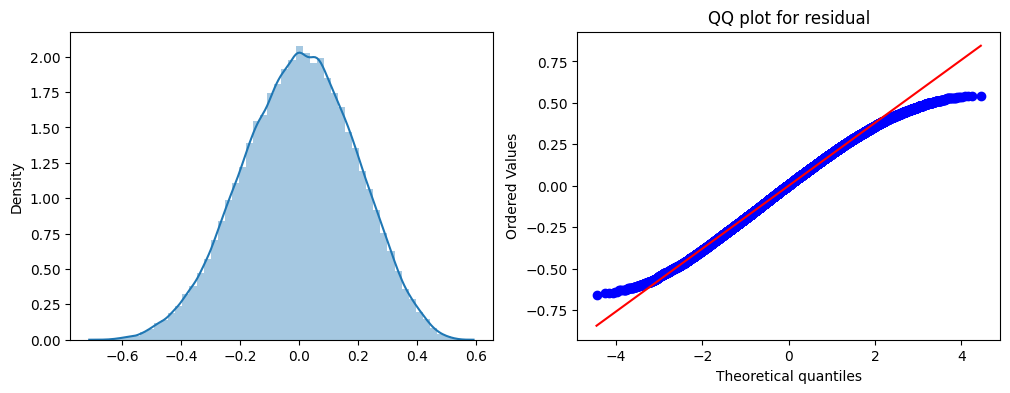

In [69]:
y_predicted = LassoModel.predict(X_train)

residuals = (y_train - y_predicted)
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
sns.distplot(residuals)
plt.subplot(1,2,2)
stats.probplot(residuals.reshape(-1,), plot = plt)
plt.title('QQ plot for residual')
plt.show()

In [70]:
y_pred = LassoModel.predict(X_test)

print("MSE:",mean_squared_error(y_test,y_pred)) # MSE
print("RMSE:",np.sqrt(mean_squared_error(y_test,y_pred))) #RMSE
print("MAE :",mean_absolute_error(y_test,y_pred) ) # MAE
print("r2_score:",r2_score(y_test,y_pred)) # r2score
print("Adjusted R2 score :", AdjustedR2score(r2_score(y_test,y_pred),len(X),X.shape[1]))  # adjusted R2 score

MSE: 0.0034789295475193297
RMSE: 0.058982451182697807
MAE : 0.04022896061335951
r2_score: 0.8198472607571161
Adjusted R2 score : 0.8172841120280507


## ElasticNet 
## L1 and L2 regularisation : 

- ### Elastic net linear regression uses the penalties from both the lasso and ridge techniques to regularize regression models.

In [71]:
## Hyperparameter Tuning : for appropriate lambda value : 

train_R2_score = []
test_R2_score = []
lambdas = []
train_test_difference_Of_R2 =  []
lambda_ = 0
while lambda_ <= 5:
    lambdas.append(lambda_)
    ElasticNet_model = ElasticNet(alpha=lambda_)
    ElasticNet_model.fit(X_train , y_train)
    trainR2 = ElasticNet_model.score(X_train,y_train)
    testR2 = ElasticNet_model.score(X_test,y_test)
    train_R2_score.append(trainR2)
    test_R2_score.append(testR2)
    
    lambda_ += 0.001

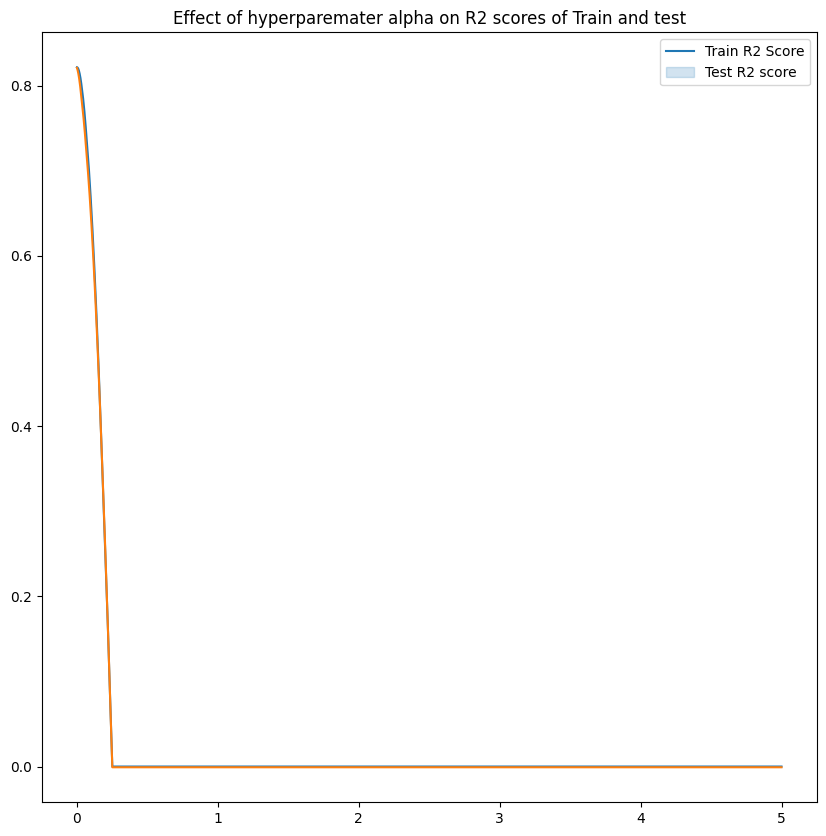

In [72]:
plt.figure(figsize = (10,10))
sns.lineplot(x=lambdas,y=train_R2_score,)
sns.lineplot(x=lambdas, y=test_R2_score)
plt.legend(['Train R2 Score','Test R2 score'])
plt.title("Effect of hyperparemater alpha on R2 scores of Train and test")


plt.show()

In [73]:
ElasticNet_model = ElasticNet(alpha=0.001)
ElasticNet_model.fit(X_train , y_train)
trainR2 = ElasticNet_model.score(X_train,y_train)
testR2 = ElasticNet_model.score(X_test,y_test)

In [74]:
trainR2,testR2

(0.8214893364453533, 0.8203602261096284)

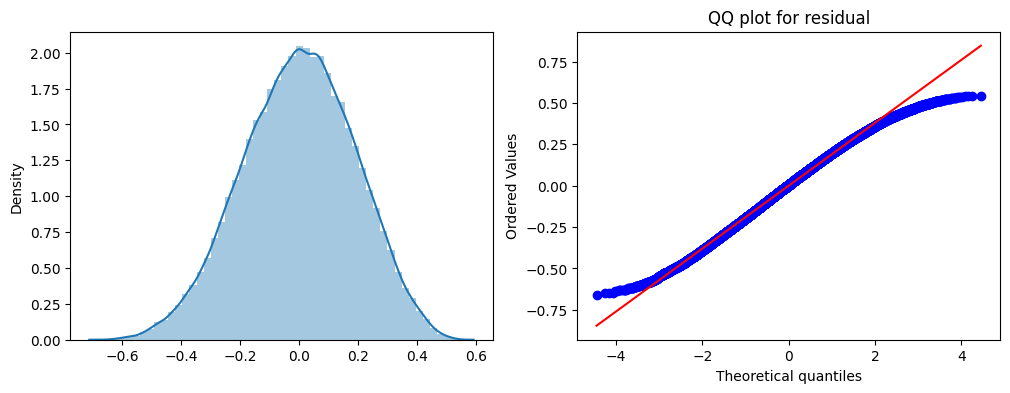

In [75]:
y_predicted = ElasticNet_model.predict(X_train)

residuals = (y_train - y_predicted)
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
sns.distplot(residuals)
plt.subplot(1,2,2)
stats.probplot(residuals.reshape(-1,), plot = plt)
plt.title('QQ plot for residual')
plt.show()

In [76]:
y_pred = ElasticNet_model.predict(X_test)

print("MSE:",mean_squared_error(y_test,y_pred)) # MSE
print("RMSE:",np.sqrt(mean_squared_error(y_test,y_pred))) #RMSE
print("MAE :",mean_absolute_error(y_test,y_pred) ) # MAE
print("r2_score:",r2_score(y_test,y_pred)) # r2score
print("Adjusted R2 score :", AdjustedR2score(r2_score(y_test,y_pred),len(X),X.shape[1]))  # adjusted R2 score

MSE: 0.003469023673596966
RMSE: 0.058898418260569324
MAE : 0.04021407699792928
r2_score: 0.8203602261096284
Adjusted R2 score : 0.8178043756680987


In [77]:
ElasticNet_model_coefs = pd.DataFrame(ElasticNet_model.coef_.reshape(1,-1),columns=df.columns[:-1])
ElasticNet_model_coefs["Intercept"] = ElasticNet_model.intercept_
ElasticNet_model_coefs

,GRE_Score,TOEFL_Score,University_Rating,SOP,LOR,CGPA,Research,Intercept
0,0.020679,0.019199,0.006908,0.00292,0.013128,0.070437,0.009581,0.722873


In [78]:
RidgeModel_coefs

,GRE_Score,TOEFL_Score,University_Rating,SOP,LOR,CGPA,Research,Intercept
0,0.020695,0.019296,0.00701,0.00299,0.013342,0.070449,0.009875,0.722882


In [79]:
Lasso_Model_coefs

,GRE_Score,TOEFL_Score,University_Rating,SOP,LOR,CGPA,Research,Intercept
0,0.020616,0.019069,0.006782,0.002808,0.012903,0.070605,0.009278,0.722863


In [80]:
LinearRegression_Model_coefs

,GRE_Score,TOEFL_Score,University_Rating,SOP,LOR,CGPA,Research,Intercept
0,0.020675,0.019284,0.007001,0.002975,0.013338,0.070514,0.009873,0.722881


In [81]:
y_pred = ElasticNet_model.predict(X_test)
ElasticNet_model_metrics = []
ElasticNet_model_metrics.append(mean_squared_error(y_test,y_pred)) # MSE
ElasticNet_model_metrics.append(np.sqrt(mean_squared_error(y_test,y_pred))) #RMSE
ElasticNet_model_metrics.append(mean_absolute_error(y_test,y_pred) ) # MAE
ElasticNet_model_metrics.append(r2_score(y_test,y_pred)) # r2score
ElasticNet_model_metrics.append(AdjustedR2score(r2_score(y_test,y_pred),len(X),X.shape[1]))  # adjusted R2 score

In [82]:
y_pred = LinearRegression.predict(X_test)
LinearRegression_model_metrics = []
LinearRegression_model_metrics.append(mean_squared_error(y_test,y_pred)) # MSE
LinearRegression_model_metrics.append(np.sqrt(mean_squared_error(y_test,y_pred))) #RMSE
LinearRegression_model_metrics.append(mean_absolute_error(y_test,y_pred) ) # MAE
LinearRegression_model_metrics.append(r2_score(y_test,y_pred)) # r2score
LinearRegression_model_metrics.append(AdjustedR2score(r2_score(y_test,y_pred),len(X),X.shape[1]))  # adjusted R2 score

In [83]:
y_pred = RidgeModel.predict(X_test)
RidgeModel_model_metrics = []
RidgeModel_model_metrics.append(mean_squared_error(y_test,y_pred)) # MSE
RidgeModel_model_metrics.append(np.sqrt(mean_squared_error(y_test,y_pred))) #RMSE
RidgeModel_model_metrics.append(mean_absolute_error(y_test,y_pred) ) # MAE
RidgeModel_model_metrics.append(r2_score(y_test,y_pred)) # r2score
RidgeModel_model_metrics.append(AdjustedR2score(r2_score(y_test,y_pred),len(X),X.shape[1]))  # adjusted R2 score

In [84]:
y_pred = LassoModel.predict(X_test)
LassoModel_model_metrics = []
LassoModel_model_metrics.append(mean_squared_error(y_test,y_pred)) # MSE
LassoModel_model_metrics.append(np.sqrt(mean_squared_error(y_test,y_pred))) #RMSE
LassoModel_model_metrics.append(mean_absolute_error(y_test,y_pred) ) # MAE
LassoModel_model_metrics.append(r2_score(y_test,y_pred)) # r2score
LassoModel_model_metrics.append(AdjustedR2score(r2_score(y_test,y_pred),len(X),X.shape[1]))  # adjusted R2 score

In [85]:
ElasticNet_model_metrics

[0.003469023673596966,
 0.058898418260569324,
 0.04021407699792928,
 0.8203602261096284,
 0.8178043756680987]

In [86]:
A = pd.DataFrame([LinearRegression_model_metrics,LassoModel_model_metrics,RidgeModel_model_metrics,ElasticNet_model_metrics],columns=["MSE","RMSE","MAE","R2_SCORE","ADJUSTED_R2"],index = ["Linear Regression Model","Lasso Regression Model","Ridge Regression Model","ElasticNet Regression Model"])
A

,MSE,RMSE,MAE,R2_SCORE,ADJUSTED_R2
Linear Regression Model,0.003459,0.058814,0.040200,0.820874,0.818326
Lasso Regression Model,0.003479,0.058982,0.040229,0.819847,0.817284
Ridge Regression Model,0.003459,0.058816,0.040203,0.820864,0.818315
ElasticNet Regression Model,0.003469,0.058898,0.040214,0.820360,0.817804


In [87]:
B = pd.DataFrame(LinearRegression_Model_coefs.append(Lasso_Model_coefs).append(RidgeModel_coefs).append(ElasticNet_model_coefs))
B.index = ["Linear Regression Model","Lasso Regression Model","Ridge Regression Model","ElasticNet Regression Model"]

In [88]:
REPORT = B.reset_index().merge(A.reset_index())


In [89]:
REPORT = REPORT.set_index("index")
REPORT

,GRE_Score,TOEFL_Score,University_Rating,SOP,LOR,CGPA,Research,Intercept,MSE,RMSE,MAE,R2_SCORE,ADJUSTED_R2
index,,,,,,,,,,,,,
Linear Regression Model,0.020675,0.019284,0.007001,0.002975,0.013338,0.070514,0.009873,0.722881,0.003459,0.058814,0.040200,0.820874,0.818326
Lasso Regression Model,0.020616,0.019069,0.006782,0.002808,0.012903,0.070605,0.009278,0.722863,0.003479,0.058982,0.040229,0.819847,0.817284
Ridge Regression Model,0.020695,0.019296,0.007010,0.002990,0.013342,0.070449,0.009875,0.722882,0.003459,0.058816,0.040203,0.820864,0.818315
ElasticNet Regression Model,0.020679,0.019199,0.006908,0.002920,0.013128,0.070437,0.009581,0.722873,0.003469,0.058898,0.040214,0.820360,0.817804


## Insights , Feature Importance and Interpretations and Recommendations : 
- fist column was observed as unique row identifier which was dropped and was not required for model building.
- University Rating , SOP and LOR strength and research are seems to be discrete random Variables , but also ordinal numeric data. 
- all the other features are numeric, ordinal and continuous.
- No null values were present in  data.
- No Significant amount of outliers were found in data.
- Chance of admission(target variable) and GRE score(an independent feature) are nearly normally distrubted. 


- Independent Variables (Input data): GRE Score, TOEFL Score, University Rating, SOP, LOR, CGPA, Research 
- Target/Dependent Variable : Chance of Admit (the value we want to predict)

- from correlation heatmap , we can observe GRE score, TOEFL score and CGPA have very high correlation with Change of admission.

- University rating, SOP ,LOR and Research have comparatively slightly less correlated than other features.


- chances of admit is a probability measure , which is within 0 to 1 which is good (no outliers or missleading data in column). 
- Range of GRE score looks like between 290 to 340.
- range of TOEFL score is between 92 to 120.
- university rating , SOP and LOR are distributed between range of 1 to 5.
- CGPA range is between  6.8 to 9.92.


- From boxplots (distribution of chance of admition (probability of getting admition) as per GRE score ) : with higher GRE score , there is high probability of getting an admition .

- Students having high toefl score , has higher probability of getting admition .




- from count plots, we can observe , statement of purpose SOP strength is positively correlated with Chance of Admission .
- we can also similar pattern in Letter of Recommendation Stength and University rating , have positive correlation with Chaces of Admission .
- Student having research has higher chances of Admission , but also we can observe some outliers within that caregory.

##### Actionable Insights and  Recommendations : 

- education institute can not just help student to improve their CGPA score but also assist them writing good LOR and SOP thus helping them admit to better university.
* The education institute can not just help student to improve their GRE Score but can also assist them writing good LOR and SOP thus helping them admit to a better University.
* Awareness of CGPA and Reserach Capabilities : Seminars can be organised to increase the awareness regarding CGPA and Research Capablities to enhance the chance of admit.
* Any student can never change their current state of attributes so awareness and marketing campaign need to surveyed hence creating a first impression on student at undergraduate level, which wont just increase company's popularity but will also help sudent get prepared for future plans in advance. 
* A dashboard can be created for students whenever they loged in into your website, hence allowing a healthy competition also to create a progress report for students.
* Additional features like number of hours they put in studing, watching lectures, assignments soved percentage, marks in mock test can result a better report for every student to judge themselves and improve on their own.


In [90]:
REPORT

,GRE_Score,TOEFL_Score,University_Rating,SOP,LOR,CGPA,Research,Intercept,MSE,RMSE,MAE,R2_SCORE,ADJUSTED_R2
index,,,,,,,,,,,,,
Linear Regression Model,0.020675,0.019284,0.007001,0.002975,0.013338,0.070514,0.009873,0.722881,0.003459,0.058814,0.040200,0.820874,0.818326
Lasso Regression Model,0.020616,0.019069,0.006782,0.002808,0.012903,0.070605,0.009278,0.722863,0.003479,0.058982,0.040229,0.819847,0.817284
Ridge Regression Model,0.020695,0.019296,0.007010,0.002990,0.013342,0.070449,0.009875,0.722882,0.003459,0.058816,0.040203,0.820864,0.818315
ElasticNet Regression Model,0.020679,0.019199,0.006908,0.002920,0.013128,0.070437,0.009581,0.722873,0.003469,0.058898,0.040214,0.820360,0.817804


<Axes: xlabel='ElasticNet Regression Model'>

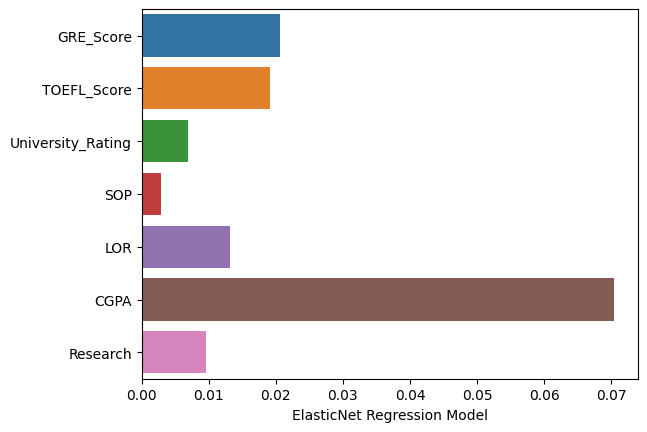

In [91]:
sns.barplot(y  = REPORT.loc["ElasticNet Regression Model"][0:7].index,
           x = REPORT.loc["ElasticNet Regression Model"][0:7])

### Regression Analysis : 

- from regression analysis (above bar chart and REPORT file), we can observe the CGPA is the most Important feature for prediciing the chances of admission. 
- other important features are GRE and TOEFL score . 

- after first Regression Model, checked for Multicolinearity . Getting all the VIF scores below 5 , showing there's no high multicolinearity.
- all the residuals are not perfectly normally distributed. and so residual plot we can observe some level of heteroscedasticity.
- regularised model ridge and lasso both give very similar results to Linear Regression Model. 
- similarly ElasticNet (L1+L2) also returns very similar results. along with rest of all the model metrics.




## Converting Analysis Report to HTML:

In [94]:
!jupyter nbconvert --to html /content/Jamboree_Final.ipynb

[NbConvertApp] Converting notebook /content/Jamboree_Final.ipynb to html
[NbConvertApp] Writing 3120468 bytes to /content/Jamboree_Final.html
